In [1]:
from cellpose import models, io
from cellpose.io import *
from collections import defaultdict
import geopandas
import glob
import imagej
from jpype import JArray, JInt
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import re
import pandas
from pandas import DataFrame
from pathlib import Path
import scyjava
import seaborn
import shutil
import tkinter as tk
from tkinter import filedialog
from PIL import Image
import sys
from zipfile import ZipFile
import csv
import random
from math import isnan 
from sklearn.cluster import AgglomerativeClustering
from PyQt5.QtWidgets import QApplication, QMainWindow, QWidget, QScrollArea, QLabel, QGridLayout
from PyQt5.QtGui import QPixmap
from PyQt5.QtCore import Qt
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn import discriminant_analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

In [ ]:
scyjava.config.add_option('-Xmx30g')
#ij = imagej.init('/home/saka/fiji-linux64/Fiji.app', mode = 'interactive')
ij = imagej.init('/home/saka/sw/local/fiji/2023', mode='interactive')
ij.ui().showUI()
ij.getVersion()

In [ ]:
showPolygonRoi = scyjava.jimport('ij.gui.PolygonRoi')
Overlay = scyjava.jimport('ij.gui.Overlay')
Regions = scyjava.jimport('net.imglib2.roi.Regions')
LabelRegions = scyjava.jimport('net.imglib2.roi.labeling.LabelRegions')
ZProjector = scyjava.jimport('ij.plugin.ZProjector')()
Duplicator = scyjava.jimport('ij.plugin.Duplicator')()
ov = Overlay()
Model =  scyjava.jimport('fiji.plugin.trackmate.Model')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Settings= scyjava.jimport('fiji.plugin.trackmate.Settings')
TrackMate = scyjava.jimport('fiji.plugin.trackmate.TrackMate')
Logger= scyjava.jimport('fiji.plugin.trackmate.Logger')
DetectorKeys= scyjava.jimport('fiji.plugin.trackmate.detection.DetectorKeys') 
ExportTracksToXML= scyjava.jimport('fiji.plugin.trackmate.action.ExportTracksToXML') 
TmXmlWriter= scyjava.jimport('fiji.plugin.trackmate.io.TmXmlWriter')
LogRecorder = scyjava.jimport('fiji.plugin.trackmate.util.LogRecorder')
SparseLAPTrackerFactory= scyjava.jimport('fiji.plugin.trackmate.tracking.jaqaman.SparseLAPTrackerFactory')
TMUtils = scyjava.jimport('fiji.plugin.trackmate.util.TMUtils')
HyperStackDisplayer = scyjava.jimport('fiji.plugin.trackmate.visualization.hyperstack.HyperStackDisplayer')
SelectionModel = scyjava.jimport('fiji.plugin.trackmate.SelectionModel')
CellposeDetectorFactory = scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeDetectorFactory')
FeatureFilter = scyjava.jimport('fiji.plugin.trackmate.features.FeatureFilter')
DisplaySetting = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettings')
DisplaySettingsIO = scyjava.jimport('fiji.plugin.trackmate.gui.displaysettings.DisplaySettingsIO')
CaptureOverlayAction = scyjava.jimport('fiji.plugin.trackmate.action.CaptureOverlayAction')
PretrainedModel= scyjava.jimport('fiji.plugin.trackmate.cellpose.CellposeSettings.PretrainedModel')
ThresholdDetectorFactory= scyjava.jimport('fiji.plugin.trackmate.detection.ThresholdDetectorFactory')
TrackScheme = scyjava.jimport('fiji.plugin.trackmate.visualization.trackscheme.TrackScheme')
TrackTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.TrackTableView')
AllSpotsTableView = scyjava.jimport('fiji.plugin.trackmate.visualization.table.AllSpotsTableView')

rm = ij.RoiManager.getRoiManager()

In [ ]:
def track_bacteria(bact, directory_path, dsettings, quality_filter, tsettings, display=False):
    '''
    This function leverages ImageJ's Trackmate plugin to track the bacteria within each single-cell video provided in the input folder bact. 
    It uses the Tresholding Detector for segmentation (with detection parameters specified in dsettings), and the LAP Tracker algorithm for tracking (with tracking parameters specified in tsettings). The function also takes as input the desired quality filter on the detected spots.
    The function saves the Trackmate XML model as well as a CSV file of the tracks for each cell in bact/Output/.
    '''
    out = bact_path+"Output/"
    if not os.path.exists(out):
        os.makedirs(out)
    for image in os.listdir(bact):
        if not image.endswith("overlay.tif"):
            if (image[len(image)-4:] == ".tif"):
                # Open Image
                imp = ij.IJ.openImage(bact + image)
                imp.show()
                ij.IJ.run("Smooth", "stack")
                ij.IJ.run("Smooth", "stack")
                # Create Model
                model = Model()
                settings = Settings(imp)
                # Detector
                settings.detectorFactory = ThresholdDetectorFactory()
                for parameter, value in dsettings.items():
                    settings.detectorSettings[parameter] = value
                filter1 = FeatureFilter('QUALITY', quality_filter, True)
                settings.addSpotFilter(filter1)
                print(settings.detectorSettings)
                # Tracker
                settings.trackerFactory = SparseLAPTrackerFactory()
                settings.trackerSettings = settings.trackerFactory.getDefaultSettings()
                for parameter, value in tsettings.items():
                    settings.trackerSettings[parameter] = value
                # Execute Tracking
                trackmate = TrackMate(model, settings)
                ok = trackmate.checkInput()
                if not ok:
                    sys.exit(str(trackmate.getErrorMessage()))
                ok = trackmate.process()
                if not ok:
                    sys.exit(str(trackmate.getErrorMessage()))
                selectionModel = SelectionModel(model)
                # Display
                ds = DisplaySettingsIO.readUserDefault()
                if display:
                    displayer = HyperStackDisplayer(model, selectionModel, imp, ds)
                    displayer.render()
                    displayer.refresh()
                    trackscheme = TrackScheme(model, selectionModel, ds)
                    trackscheme.render()
                # Save Data
                basename_image = os.path.basename(image)
                corename = os.path.splitext(basename_image)[0]
                outFile = Path(out+corename+"_exportModel.xml")
                writer = TmXmlWriter(outFile)
                writer.appendModel(model)
                writer.appendSettings(settings)
                writer.writeToFile()
                csvFileSpots = out+corename+"_exportTracks.csv"
                spotsTableView = AllSpotsTableView(model, selectionModel, ds)
                spotsTableView.exportToCsv(csvFileSpots)
        ij.py.run_macro('close("*")')
    
def merge_trackmate_rois(bact_path, directory_path):
    '''
    This function seeks to assign bacterial ROIs to tracks by merging the results of tracking (via Trackmate) and ROI detection (via Thresholding in ImageJ). It matches ROIs to spots detected in Trackmate based on the nearest centroid.
    For each cell, the function saves a CSV file of tracks and their corresponding ROIs in a folder called grouped.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    out = directory_path+"grouped/"
    if not os.path.exists(out):
        os.makedirs(out)
    for file_path in file_list:
        if not file_path.endswith("overlay.tif"):
            filename = os.path.basename(file_path)
            filename2 = os.path.splitext(filename)[0]
            first = Path(f"{bact_path}/Output/{filename2}_exportTracks.csv").as_posix()
            second = Path(f"{bact_path}/{filename2}_bactROI.csv").as_posix()
            pairwise = xref_locations(first, second, 
                                  first_x='POSITION_X', 
                                  first_y='POSITION_Y', 
                                  first_z='POSITION_Z', 
                                  second_x='X', 
                                  second_y='Y', 
                                  second_z='Slice', 
                                  verbose=False)
            grouped = pairwise.groupby('ID', group_keys=False)[pairwise.columns[12]].apply(list).reset_index()
            grouped.rename(columns={'index_right': 'object_ID_list'}, inplace=True)
            final_csv = Path(f"{directory_path}/grouped/{filename2}_grouped.csv")
            grouped.to_csv(final_csv)
            final_csv2 = Path(f"{directory_path}/grouped/{filename2}_pairwise.csv")
            pairwise.to_csv(final_csv2)
    return out

def apply_bact_overlays(bact_path, grouped):
    '''
    This function allows for visual quality-control of the bacterial-tracking step by adding colored overlays to the bacterial tracks in each single-cell video. Bacterial clusters of the same track remain the same color from frame to frame.
    All of the overlayed videos are saved in the folder bact with the title [cell_number]_overlay.tif.
    '''
    file_pattern = os.path.join(bact_path, "*.tif")
    file_list = glob.glob(file_pattern)
    colors = ["blue", "cyan", "green", "magenta", "orange", "red", "yellow"]
    for file_path in file_list: # cycle through images, open them and open the matching "grouped' csv file
        if not file_path.endswith("overlay.tif"):
            imp = ij.IJ.openImage(file_path)
            ij.ui().show(imp)
            f_name = os.path.basename(file_path)
            f_name = os.path.splitext(f_name)[0]
            input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
            df = pandas.read_csv(input_csv)
            pouet = df['object_ID_list']
            input_ROI = Path(f"{bact_path}/{f_name}_bactROI.zip")
            rm.open(f"{input_ROI}")
            for i in range(len(pouet)):
                single_row = df.iloc[i]
                random_color = random.choice(colors)
                row_cellids = single_row.object_ID_list
                row_cleaned = row_cellids.strip('[').strip(']')
                row_array = row_cleaned.split(', ')
                for cell in row_array:
                    cell_index = int(cell)
                    roi = rm.select(cell_index)
                    overlay_command = f"Overlay.addSelection('{random_color}',2);"
                    ij.py.run_macro(overlay_command)
            ij.py.run_macro("setMinAndMax(0, 100);")
            ij.py.run_macro("run('Flatten', 'stack');")
            method = 'max all'
            z_projector_result = ZProjector.run(imp, method)
            z_collapsed_image = ij.py.from_java(z_projector_result)
            z_collapsed_dataset = ij.py.to_dataset(z_projector_result)
            result_path = os.path.splitext(file_path)[0] + "_overlay.tif"
            if os.path.exists(result_path):
                os.remove(result_path)
            saved = ij.io().save(z_collapsed_dataset, result_path)       
            ij.py.run_macro("close();")
            rm.runCommand("Reset")

def xref_locations(first, second, first_x='POSITION_X', first_y='POSITION_Y', first_z='POSITION_Z',
                   second_x='X', second_y='Y', second_z='Slice',
                   max_dist=20, verbose=False):
    pairwise_elements = pandas.DataFrame()
    first_measurements = pandas.read_csv(first)
    first_measurements = first_measurements.drop([0,1,2])
    second_measurements = pandas.read_csv(second)
    first_gdf = geopandas.GeoDataFrame(
        first_measurements,
        geometry=geopandas.points_from_xy(first_measurements[first_x],
                                          first_measurements[first_y],
                                          first_measurements[first_z]))
    second_gdf = geopandas.GeoDataFrame(
        second_measurements,
        geometry=geopandas.points_from_xy(second_measurements[second_x],
                                          second_measurements[second_y],
                                          second_measurements[second_z]))
    ti_rows = first_gdf.shape[0]
    tj_rows = second_gdf.shape[0]
    for ti_row in range(0, ti_rows):
        if verbose:
            print(f"On row: {ti_row}")
        ti_element = first_gdf.iloc[[ti_row, ]]
        
        titj = geopandas.sjoin_nearest(ti_element, second_gdf,
                                       distance_col="pairwise_dist",
                                       max_distance=max_dist)
        chosen_closest_dist = titj.pairwise_dist.min()
        if (isnan(chosen_closest_dist)):
            print(f"This element has no neighbor within {max_dist}.")
        else:
            chosen_closest_cell = titj.pairwise_dist == chosen_closest_dist
            chosen_closest_row = titj[chosen_closest_cell]
            pairwise_tmp = pandas.concat([pairwise_elements, chosen_closest_row])
            pairwise_elements = pairwise_tmp
    return pairwise_elements

In [ ]:
#define your parent directory
directory_path = '/home/saka/Documents/Lab_stuff/confocal/20230622  THP1LC3 gal3 alix osbp/gal3/'

#Creation of different directory for outputs
bact_path = directory_path + "bact/"
if not os.path.exists(bact_path):
    os.makedirs(bact_path)
measurement_path = directory_path + "measurement/"
if not os.path.exists(measurement_path):
    os.makedirs(measurement_path)
channels_path = directory_path + "channels/"
if not os.path.exists(channels_path):
    os.makedirs(channels_path)
voronoi_path = directory_path + "voronoi/"
if not os.path.exists(voronoi_path):
    os.makedirs(voronoi_path)

In [ ]:
format = f'Tiff'
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    raw_image = image = ij.io().open(file_path)
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    LC3_channel = 2
    channel = raw_image[:, :, LC3_channel, :]
    lc3 = ij.py.to_imageplus(channel)
    lc3.setDimensions(1, 11, 1)
    #ij.ui().show(lc3)
    result_path = f"{channels_path}/LC3_channel_{corename}.tif"
    ij.IJ.saveAs(lc3, "Tiff", ij.py.to_java(result_path))
    
    gal3_channel = 0
    channel = raw_image[:, :, gal3_channel, :]
    gal3 = ij.py.to_imageplus(channel)
    gal3.setDimensions(1, 11, 1)
    result_path = f"{channels_path}/osbp_channel_{corename}.tif"
    ij.IJ.saveAs(gal3, "Tiff", ij.py.to_java(result_path))
    
    bact_channel = 1
    channel = raw_image[:, :, bact_channel, :]
    bact = ij.py.to_imageplus(channel)
    bact.setDimensions(1, 11, 1)
    result_path = f"{bact_path}/bact_channel_{corename}.tif"
    ij.IJ.saveAs(bact, "Tiff", ij.py.to_java(result_path))

    method = 'max'
    nuclei_channel = 3
    blue_channel = raw_image[:, :, nuclei_channel,:]
    sigma = 1.5  # Adjust the value of sigma as needed
    smoothed_image = ij.op().run("smooth", blue_channel, sigma)
    imp = ij.py.to_imageplus(smoothed_image) # convert the image into the imageplus type object needed for z-projection
    # Z-projection
    z_projector_result = ZProjector.run(imp, method)
    z_collapsed_image = ij.py.from_java(z_projector_result)
    z_collapsed_dataset = ij.py.to_dataset(z_collapsed_image)  
    # Save as a TIFF imagerm.open(f"{input_roi}")
    result_path = f"{voronoi_path}/{corename}_max_nuclei_channel.tif"
    ij.io().save(z_collapsed_dataset, result_path)
    print(f"Saving image {result_path}.")

In [ ]:
file_pattern = os.path.join(voronoi_path, "*nuclei_channel.tif")
file_list = glob.glob(file_pattern)
model = models.CellposeModel(gpu=True, model_type='THP1_nuclei')
for file_path in file_list:
    imgs = io.imread(file_path)
    channels = [[0,0]]
    masks, flows, styles = model.eval(imgs, diameter=None, channels=channels)
    io.save_to_png(imgs, masks, flows, file_path)

In [ ]:
for file_path in file_list:
    image_red = ij.io().open(file_path)
    imp = ij.py.to_imageplus(image_red)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    input_txt = Path(f"{voronoi_path}/{f_name}_cp_outlines.txt")
    txt_fh = open(input_txt, 'r')
    for line in txt_fh:
        xy = line.rstrip().split(",")
        xy_coords = [int(element) for element in xy if element not in '']
        x_coords = [int(element) for element in xy[::2] if element not in '']
        y_coords = [int(element) for element in xy[1::2] if element not in '']
        xcoords_jint = JArray(JInt)(x_coords)
        ycoords_jint = JArray(JInt)(y_coords)
        polygon_roi_instance = scyjava.jimport('ij.gui.PolygonRoi')
        roi_instance = scyjava.jimport('ij.gui.Roi')
        imported_polygon = polygon_roi_instance(xcoords_jint, ycoords_jint, len(x_coords), int(roi_instance.POLYGON))
        imp.setRoi(imported_polygon)
        rm.addRoi(imported_polygon)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{voronoi_path}/" + f"{f_name}.zip")
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Delete")

In [ ]:
for file_path in file_list:
    image = ij.io().open(file_path)
    f_name = os.path.basename(file_path)
    f_name = os.path.splitext(f_name)[0]
    input_ROI = f"{voronoi_path}/{f_name}.zip"
    rm.open(input_ROI)
    ij.ui().show(image)
    #to better draw, apply and save ROIs, the image should be displayed:
    imp = ij.py.to_imageplus(image) 
    roi_count = rm.getCount()
    for i in range(roi_count):
        rm.select(i)
        shrinking = ij.IJ.run("Enlarge...", "enlarge=-1 pixel")
        rm.runCommand("update")
    rm.runCommand("Select All")
    rm.runCommand("XOR")
    rm.runCommand("Fill")
    rm.runCommand("Select All")
    rm.runCommand("XOR")
    ij.IJ.run("Clear Outside")
    rm.runCommand("Select All")
    rm.runCommand("Delete")
    ij.py.run_macro('setAutoThreshold("Default dark no-reset");')
    ij.IJ.run("Threshold...")
    ij.py.run_macro('setThreshold(5, 255);')
    ij.py.run_macro('setOption("BlackBackground", true);')
    ij.IJ.run("Convert to Mask", "black")
    
    voronoi = """
run("Set Measurements...", "center redirect=None decimal=1");
run("Analyze Particles...","size=3-Infinity display clear");
//Resolution de l'image pwidth et pheight
getPixelSize(unit, pw, ph, pd);
//Voronio
run("Voronoi");
setThreshold(0, 0,"black & white");

//Wand to ROI Manager
x=newArray(nResults);
y=newArray(nResults);
nbPoints=nResults;

for (i=0; i<nbPoints; i++) {
    x[i]=getResult("XM",i)/pw;
    y[i]=getResult("YM",i)/ph;
}
for (i=0; i<nbPoints; i++) {
    doWand(x[i], y[i], 156.0, "Legacy");
    roiManager("Add");
}

//Center of mass
/*
x=newArray(nResults);
y=newArray(nResults);
for (i=0; i<nResults; i++) {
    x[i]=getResult("XM",i)/pw;
    y[i]=getResult("YM",i)/ph;
}
*/
makeSelection("point", x, y);
selectWindow("Results");
run("Close");
close("*");
"""
    run_voronoi = ij.py.run_macro(voronoi)
    ij.py.run_macro("roiManager('Select All');")
    rm.runCommand("Save", f"{voronoi_path}/" + f"{f_name}_voronoi.zip")
    rm.runCommand("Delete")

In [ ]:
file_pattern = os.path.join(bact_path, "*.tif")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    if not file_path.endswith('overlay.tif'):
        image = ij.io().open(file_path)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        ij.ui().show(image)
        ij.IJ.run("Smooth", "stack")
        ij.IJ.run("Smooth", "stack")
        roi_collection = """
        setAutoThreshold("Default dark no-reset");
        run("Threshold...");
        setThreshold(8, 255);
        setOption("BlackBackground", true);
        run("Convert to Mask", "black");  
        run("Analyze Particles...", "size=10-Infinity add stack");
        run("Set Measurements...", "area centroid stack redirect=None decimal=2");
        nbArea=roiManager("count")
        for (i=0; i<nbArea; i++) {
        	roiManager("Select", i);
        	run("Measure");	
        }
        close("*");
        //close();
        """
        rois = ij.py.run_macro(roi_collection)
        rm.runCommand("Select All")
        rm.runCommand("Save", f"{bact_path}/" + f"{f_name}_bactROI.zip") # this saves the ROIs as a zip file
        rm.runCommand("Delete")
        output_path = f"{bact_path}/{f_name}_bactROI.csv" # save giving a name matching the opened image
        saving = ij.IJ.saveAs("Results", output_path)
        ij.IJ.run("Clear Results")

In [ ]:
dsettings = { # specify parameters for the detection step in Trackmate (Threshold Detector)
    'TARGET_CHANNEL' : ij.py.to_java(1),
    'SIMPLIFY_CONTOURS' : False,
    'INTENSITY_THRESHOLD' : 8.0,
}
quality_filter = 50
tsettings = { # specify parameters for the tracking step in Trackmate (LAP Tracker)
    'LINKING_MAX_DISTANCE' : 100.0,
    'ALLOW_GAP_CLOSING' : True,
    'GAP_CLOSING_MAX_DISTANCE' : 45.0,
    'MAX_FRAME_GAP' : ij.py.to_java(2),
    'ALLOW_TRACK_SPLITTING' : False,
    'SPLITTING_MAX_DISTANCE' : 15.0,
    'ALLOW_TRACK_MERGING' : False,
}

In [ ]:
track_bacteria(bact_path, directory_path, dsettings, quality_filter, tsettings, False)

In [ ]:
grouped = merge_trackmate_rois(bact_path, directory_path)

In [ ]:
apply_bact_overlays(bact_path, grouped)

In [ ]:
print(file_list)

In [ ]:
channels_image = directory_path+'channels.tif'
max_channels = directory_path+'max_channels.tif'
sum_channels = directory_path+'sum_channels.tif'
tracks_csv = directory_path+'da_Tracks.csv'
sorted_tm_tracks_csv = directory_path+'exportTracks_edited.csv'
tm_tracks_csv = directory_path+'exportTracks.csv'
roiset = directory_path+'rois/'
bact_path = directory_path+'bact/'
other = directory_path+'other/'
grouped = directory_path+'grouped/'
measurements = directory_path+'measurement/'
channels = directory_path+'channels/'

In [ ]:
run("Set Measurements...", "mean redirect=None decimal=4");
n=roiManager("count")
for (i=0; i<n; i++) {
		roiManager("Select", i);
		run("Enlarge...", "enlarge=5 pixel");
		roiManager("Add");
roiIndexes = newArray(i,n+i);
		roiManager("Select", roiIndexes);
		roiManager("XOR");
		run("Measure");	
	}

In [ ]:
file_pattern = os.path.join(bact_path, "*.tif")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    if not file_path.endswith('overlay.tif'):
        basename = os.path.basename(file_path)
        corename = os.path.splitext(basename)[0]
        bact_roi_path = bact_path + f"rois_bact/{corename}"
        if not os.path.exists(bact_roi_path):
            os.makedirs(bact_roi_path)
        imp = ij.IJ.openImage(file_path)
        ij.ui().show(imp)
        f_name = os.path.basename(file_path)
        f_name = os.path.splitext(f_name)[0]
        input_csv = Path(f"{grouped}/{f_name}_grouped.csv")
        df = pandas.read_csv(input_csv)
        pouet = df['object_ID_list']
        input_ROI = Path(f"{bact_path}/{f_name}_bactROI.zip")
        rm.open(f"{input_ROI}")
        for i in range(len(pouet)):
            single_row = df.iloc[i]
            row_cellids = single_row.object_ID_list
            row_cleaned = row_cellids.strip('[').strip(']')
            row_array = row_cleaned.split(', ')
            for cell in row_array:
                cell_index = int(cell)
                roi = rm.select(cell_index)
                output = f"{bact_roi_path}/{cell_index}.roi"
                saved = rm.runCommand("Save", output)
        rm.runCommand("Reset")
        ij.py.run_macro('close("*");')

### function circles around bacteria

In [ ]:
def circlesofhell(bact_path, bact_roi_path, channel):
    roi_pattern = os.path.join(bact_roi_path, "*.roi")
    roi_list = glob.glob(roi_pattern)
    for roi in roi_list:
        roi_basename = os.path.basename(roi)
        roi_corename = os.path.splitext(roi_basename)[0]
        open_roi = rm.open(roi)
        rm.select(0)
        enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
        rm.addRoi(enlarged)
        for n in range(0,3):
            rm.select(1+n)
            enlarged = ij.IJ.run("Enlarge...", "enlarge=1 pixel")
            rm.addRoi(enlarged)
        rm.select(0)
        ij.IJ.run("Measure")
        ij.IJ.run("Make Band...", "band=1")
        ij.IJ.run("Measure")
        for n in range(0,4):
            rm.select(1+n)
            ij.IJ.run("Make Band...", "band=1")
            ij.IJ.run("Measure")
        rm.runCommand("Reset")
        output_path = f"{bact_roi_path}/{roi_corename}_{channel}.csv"
        saving = ij.IJ.saveAs("Results", output_path)
        ij.IJ.run("Clear Results")    

### running it over multiple images

In [ ]:
distance = 1024 # scale
known_scale = 224.48
unit = "µm"
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
cois = ['osbp_channel', 'LC3_channel']
set_string = f'Set Measurements...'
measure_string = f'mean area integrated stack redirect=None decimal=2'
ij.IJ.run(set_string, measure_string)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    for channel in cois:
        image_path = f"{channels}/{channel}_{corename}.tif"
        imp = ij.IJ.openImage(image_path)
        imp.show()
        ij.py.run_macro(f'run("Set Scale...", "distance={distance} known={known_scale} unit={unit}");')    
        rings = circlesofhell(bact_path, bact_roi_path, channel)
        ij.py.run_macro('close("*");')

### combining multiple csv

In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('LC3_channel.csv'):
            df= pandas.read_csv(csv)
            df.rename(columns={df.columns[0]: 'circle'}, inplace=True)
            plt.plot(df['circle'], df['IntDen'])


In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('gal3_channel.csv'):
            df= pandas.read_csv(csv)
            df.rename(columns={df.columns[0]: 'circle'}, inplace=True)
            plt.plot(df['circle'], df['IntDen'])

In [ ]:
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
df_lc3_list = []
df_gal3_list = []

df_lc3 = pandas.DataFrame({'circle': [1, 2, 3, 4, 5, 6]})
df_lc3_list.append(df_lc3['circle'])
df_gal3 = pandas.DataFrame({'circle': [1, 2, 3, 4, 5, 6]})
df_gal3_list.append(df_lc3['circle'])

for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    file_pattern2 = os.path.join(bact_roi_path, "*.csv")
    file_list2 = glob.glob(file_pattern2)
    for csv in file_list2:
        if csv.endswith('LC3_channel.csv'):
            df= pandas.read_csv(csv)
            norm_raw = []
            basename = os.path.basename(csv)
            roi_number = basename.split("_")[0]
            cell_name = f"{corename}_{roi_number}"
            for i in range(len(df)):
                ratio = df['RawIntDen'][i] / df['Area'][i]
                norm_raw.append(ratio)
            df[cell_name] = norm_raw   
            df_lc3_list.append(df[cell_name])

        if csv.endswith('osbp_channel.csv'):
            df= pandas.read_csv(csv)
            norm_raw = []
            basename = os.path.basename(csv)
            roi_number = basename.split("_")[0]
            cell_name = f"{corename}_{roi_number}"
            for i in range(len(df)):
                ratio = df['RawIntDen'][i] / df['Area'][i]
                norm_raw.append(ratio)
            df[cell_name] = norm_raw 
            df_gal3_list.append(df[cell_name])
            
result_lc3 = pandas.concat(df_lc3_list, axis=1)
result_gal3 = pandas.concat(df_gal3_list, axis=1)    
result_lc3.to_csv(f"{directory_path}LC3_numbers.csv")
result_gal3.to_csv(f"{directory_path}osbp_numbers.csv")

In [ ]:
csv1 = f"{directory_path}LC3_numbers.csv"
csv2 = f"{directory_path}gal3_numbers.csv"
df= pandas.read_csv(csv1)
df.head()

In [ ]:
csv2 = f"{directory_path}gal3_numbers.csv"
df2= pandas.read_csv(csv2)
for i in range (2, len(df2.columns)):
    plt.plot(df2['circle'], df2[df2.columns[i]])

In [ ]:
for i in range (2, len(df.columns)):
    plt.plot(df['circle'], df[df.columns[i]])

In [ ]:
csv3 = f"{directory_path}gal3_numbers_delta2.csv"
df2= pandas.read_csv(csv3)
for i in range (2, len(df2.columns)):
    plt.plot(df2['circle'], df2[df2.columns[i]])

In [ ]:
print (len(df2.columns))

In [ ]:
for i in range(len(df)):
    # If the current cell value in the "Slice" column is 1,
    if df['Slice'][i] == 1:
        # Sum the "Total Area" column for the next 10 rows.
        #slice_number = 10  # You need to define slice_number and slice_distance
        #slice_distance = 1  # You need to define slice_number and slice_distance
        bacterial_area = df['Total Area'][i:i + slice_number].sum()
        bacterial_volume = bacterial_area * slice_distance
        # Create a DataFrame with the current pattern number and the total area.
        result_df = pandas.DataFrame({'bacterial_volume': [bacterial_volume]}, index=[i])
        results.append(result_df)

In [ ]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()

In [ ]:
df = pandas.read_csv(dataset)

In [ ]:
norm_raw = []
for i in range(len(df)):
    ratio = df['RawIntDen'][i] / df['Area'][i]
    norm_raw.append(ratio)
df['RawIntDen/Area'] = norm_raw
df.head()

In [ ]:
root = tk.Tk()
root.withdraw()
dataset = filedialog.askopenfilename()

In [ ]:
# save a montage of each MCV
file_pattern = os.path.join(directory_path, "*.czi")
file_list = glob.glob(file_pattern)
w = scyjava.jimport('ij.WindowManager')
for file_path in file_list:
    basename = os.path.basename(file_path)
    corename = os.path.splitext(basename)[0]
    bact_roi_path = bact_path + f"rois_bact/bact_channel_{corename}"
    imp = ij.IJ.openImage(file_path)
    imp.show()
    imp.setDisplayMode(1)
    imp.setC(1)
    ij.IJ.run(imp, "Red", "")
    ij.py.run_macro("setMinAndMax(0, 100);")
    imp.setC(2)
    ij.IJ.run(imp, "Blue", "")
    ij.py.run_macro("setMinAndMax(0, 100);")
    imp.setC(3)
    ij.IJ.run(imp, "Green", "")
    ij.py.run_macro("setMinAndMax(0, 100);")
    imp.setC(4)
    ij.IJ.run(imp, "Grays", "")
    #ij.IJ.run(imp, "RGB Color", "slices")
    roi_pattern = os.path.join(bact_roi_path, "*.roi")
    roi_list = glob.glob(roi_pattern)
    for roi in roi_list:
        roi_basename = os.path.basename(roi)
        roi_corename = os.path.splitext(roi_basename)[0]
        open_roi = rm.open(roi)    
        roi = rm.getRoi(0)
        selected = rm.select(0)
        x = roi.getContourCentroid()[0]
        y = roi.getContourCentroid()[1]
        square = imp.setRoi(int(x-20), int(y-20), 40, 40)
        added = rm.addRoi(square)
        roi2 = rm.getRoi(1)
        roi3 = rm.select(1)
        square_name = f"{corename}_{roi_corename}"
        ij.IJ.run("Duplicate...", f"title={str(square_name)}")
        new_vid =  w.getImage(str(square_name))
        ij.IJ.run(new_vid, "Make Montage...", "columns=4 rows=1 scale=2 border=1")
        new_montage =  w.getImage("Montage")
        output_path = f"{measurement_path}{square_name}.tif"
        if os.path.exists(output_path):
            os.remove(output_path)
        ij.IJ.save(new_montage, output_path)
        rm.reset()
        w.getImage("Montage").close()
        w.getImage(str(square_name)).close()
        ij.IJ.selectWindow(imp.getTitle())
    ij.py.run_macro('close("*");')

# Categorizing the stainings

In [2]:
directory_path = '/home/saka/Documents/Lab_stuff/confocal/20230622  THP1LC3 gal3 alix osbp/gal3/'
measurements = directory_path+'measurement/'

In [3]:
csv_lc3 = f"{directory_path}LC3_numbers.csv"
csv_gal3 = f"{directory_path}gal3_numbers.csv"
df_lc3 = pandas.read_csv(csv_lc3)
df_gal3 = pandas.read_csv(csv_gal3) 

In [4]:
def df_cleaning(df):
    df_transposed = df.transpose()
    df_cleaned = df_transposed.drop(["Unnamed: 0","circle"])
    df_cleaned.rename(columns={df_cleaned.columns[0]: 'd0', 
                               df_cleaned.columns[1]: 'd1',  
                               df_cleaned.columns[2]: 'd2', 
                               df_cleaned.columns[3]: 'd3', 
                               df_cleaned.columns[4]: 'd4', 
                               df_cleaned.columns[5]: 'd5'}, inplace=True)
    df_cleaned_sorted = df_cleaned.sort_index()
    df_norm = df_cleaned_sorted.sub(df_cleaned_sorted.mean(axis=1), axis=0)
    df_norm.head()
    for idx, row in df_norm.iterrows():
        plt.plot(range(len(row)),row)
    plt.xlabel('distance')
    plt.ylabel('Measurement')
    #plt.legend()
    plt.show()
    return df_norm, df_cleaned_sorted


def curves_clustering(df_norm, cluster_number = 10):
    clustering = AgglomerativeClustering(n_clusters=cluster_number)
    clustering.fit(df_norm)
    experiment_labels = clustering.labels_
    df_norm['cluster'] = experiment_labels
    # Print the labels
    #print(experiment_labels)
    for cluster_num in df_norm['cluster'].unique():
        # Filter data for the current cluster
        cluster_data = df_norm[df_norm['cluster'] == cluster_num]
        
        # Plot the data for the current cluster
        plt.figure(figsize=(8, 6))
        for idx, row in cluster_data.iterrows():
            plt.plot(range(len(row)-1), row[:-1], label=idx)  # Exclude the last column 'cluster' from plotting
        plt.title(f'Cluster {cluster_num} Data')
        plt.xlabel('distance')
        plt.ylabel('Measurement')
        #plt.legend()
        plt.show()

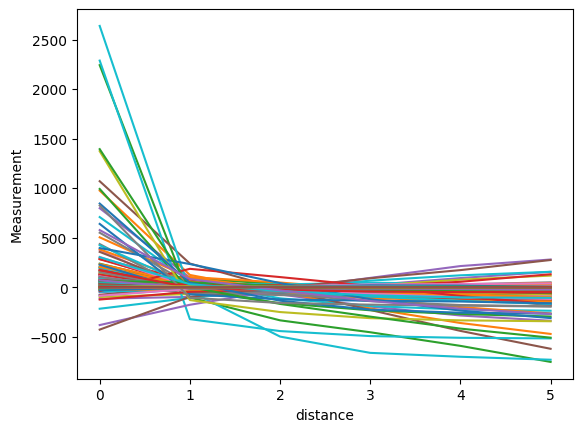

In [5]:
df_lc3_norm, df_lc3_cleaned_sorted = df_cleaning(df_lc3)

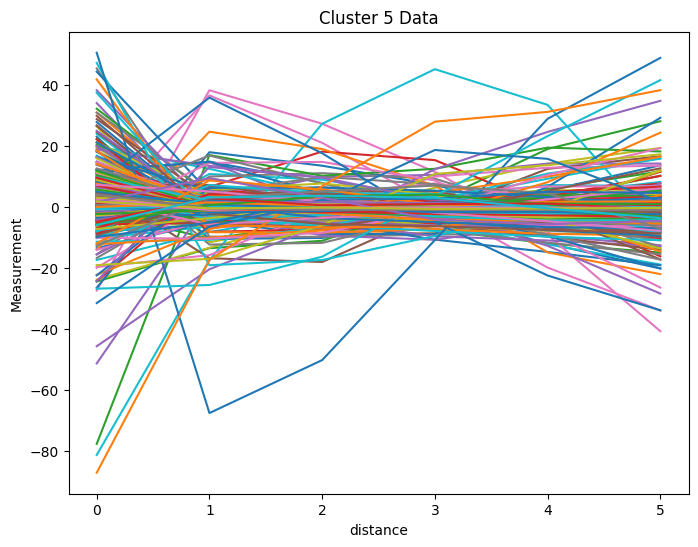

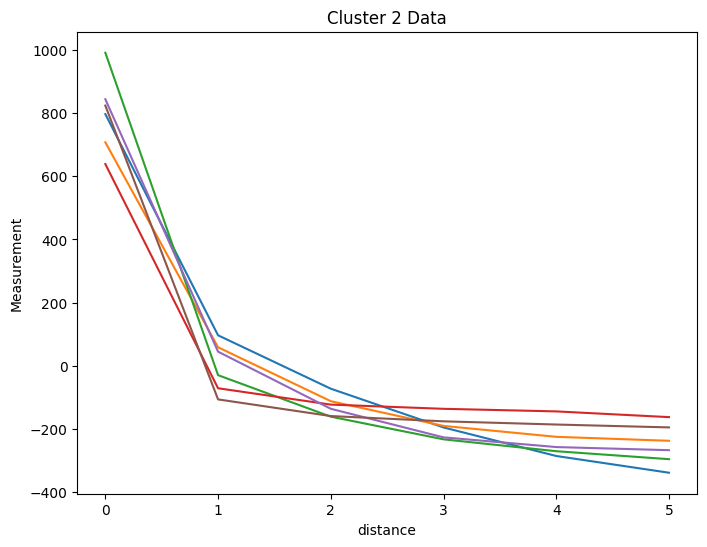

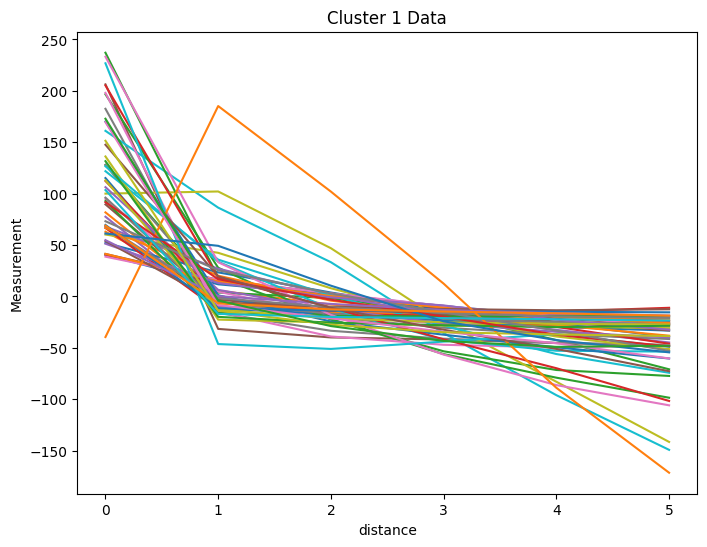

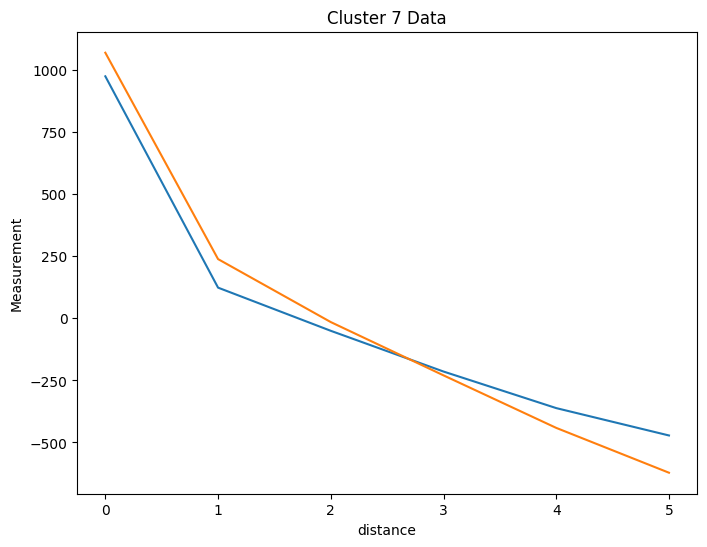

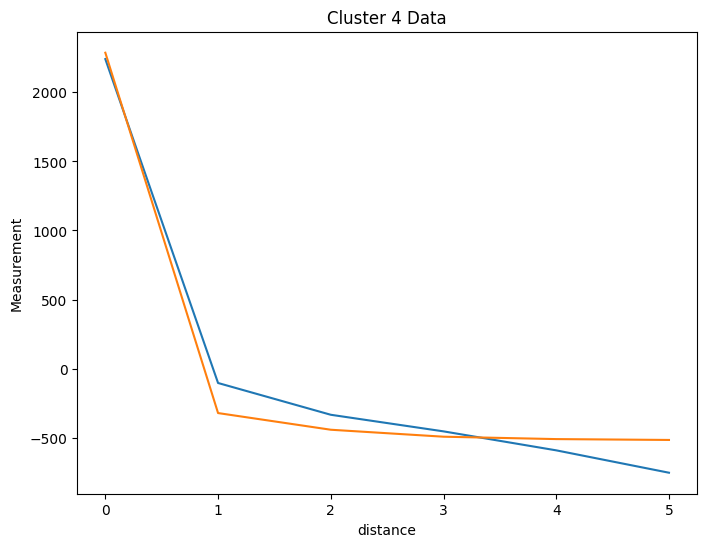

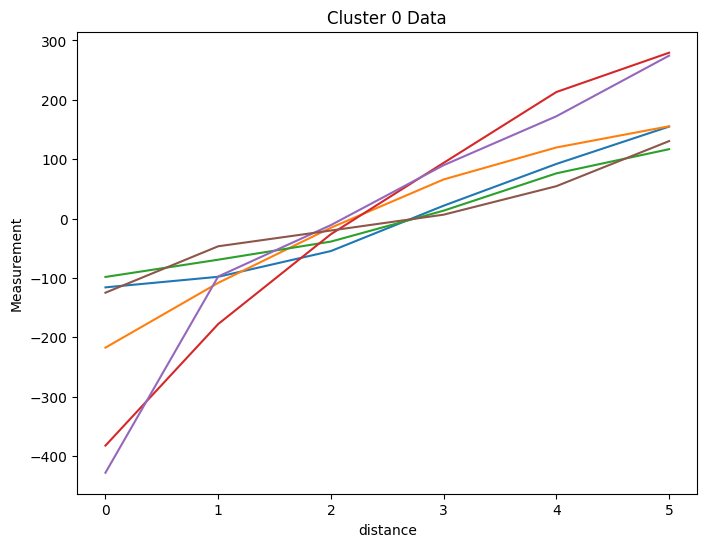

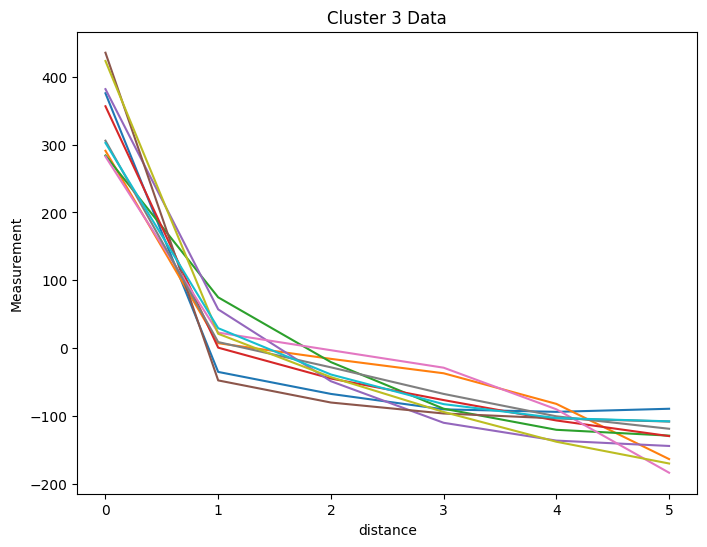

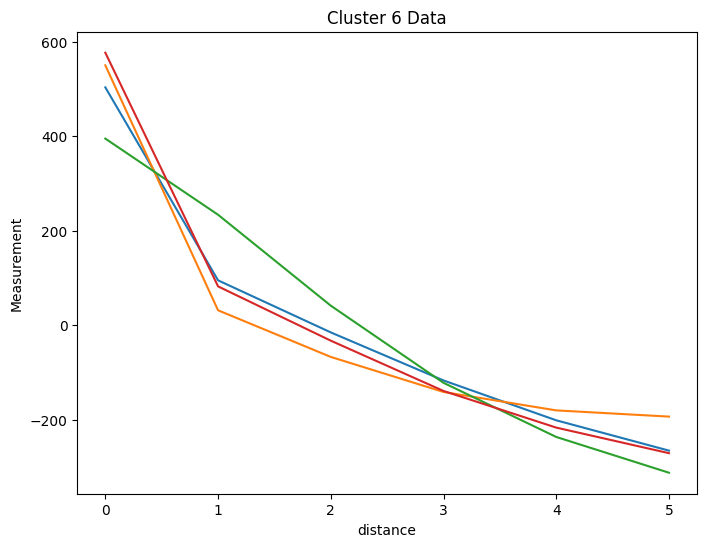

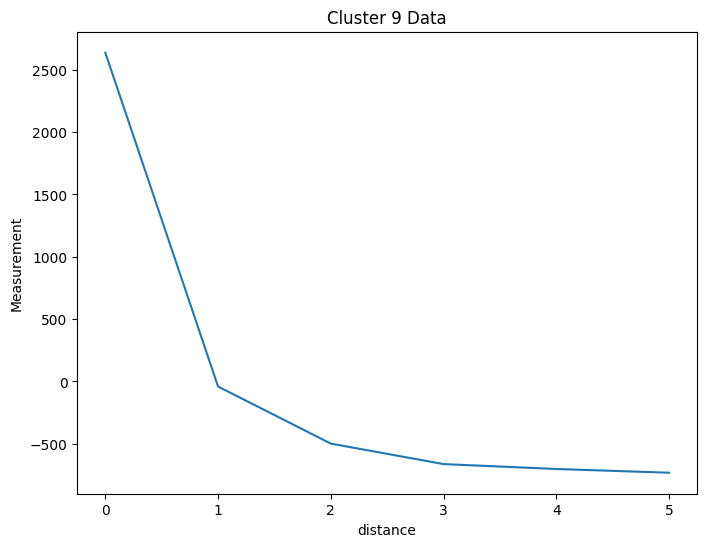

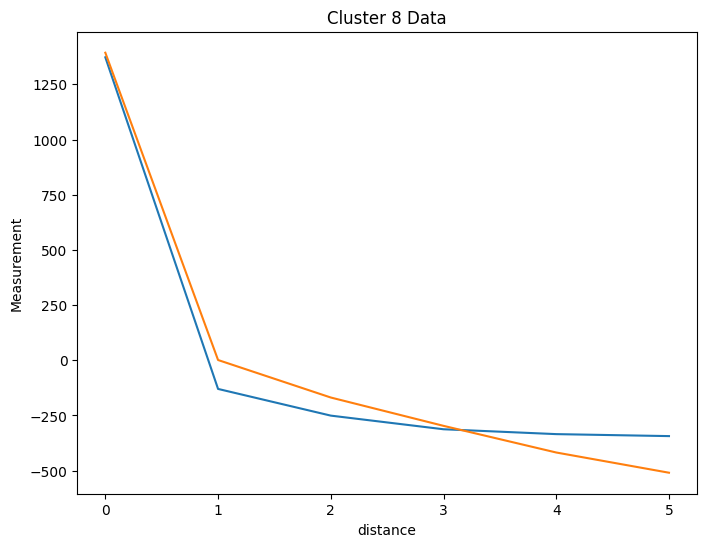

In [6]:
clustering = curves_clustering(df_lc3_norm, cluster_number = 10)

In [ ]:
image_list = []
cluster_num = 1
for i in range(len(df_lc3_norm)):
    if df_lc3_norm['cluster'][i] == cluster_num:
        image = df_lc3_norm.index[i]
        image_path = Path(f"{measurements}{image}.tif").as_posix()
        image_list.append(image_path)

In [ ]:
class MainWindow(QMainWindow):

    def __init__(self, image_list):
        super().__init__()
        self.image_list = image_list
        self.window()
    
    def window(self):
        self.scroll = QScrollArea()
        self.win = QWidget()
        self.grid = QGridLayout()

        num_images = len(self.image_list)
        num_columns = 4  # Fixed number of columns
        num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows dynamically

        n = 0
        for i in range(num_rows):
            for j in range(num_columns):
                if n < num_images:
                    file = self.image_list[n]
                    pixmap = QPixmap(file)
                    pixmap2 = pixmap.scaled(500, 200, Qt.KeepAspectRatio)
                    label = QLabel(pixmap=pixmap2)
                    self.grid.addWidget(label, i, j)
                    n += 1
    
        self.win.setLayout(self.grid)
        self.scroll.setWidgetResizable(True)
        self.scroll.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setWidget(self.win)
        self.setCentralWidget(self.scroll)
        self.setGeometry(0, 0, 2300, 1000)
        self.setWindowTitle('Image Viewer')
        self.show()

def main():
    app = QApplication(sys.argv)
    main = MainWindow(image_list)
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

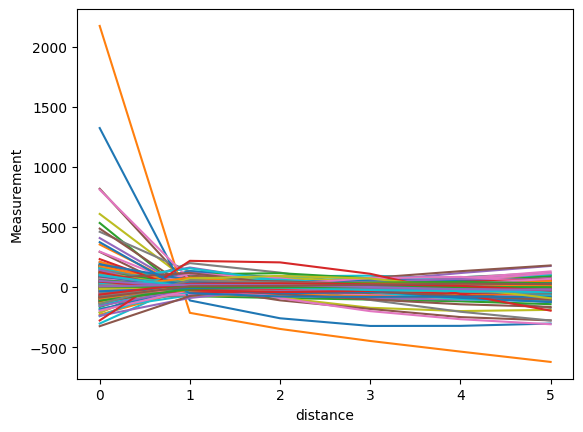

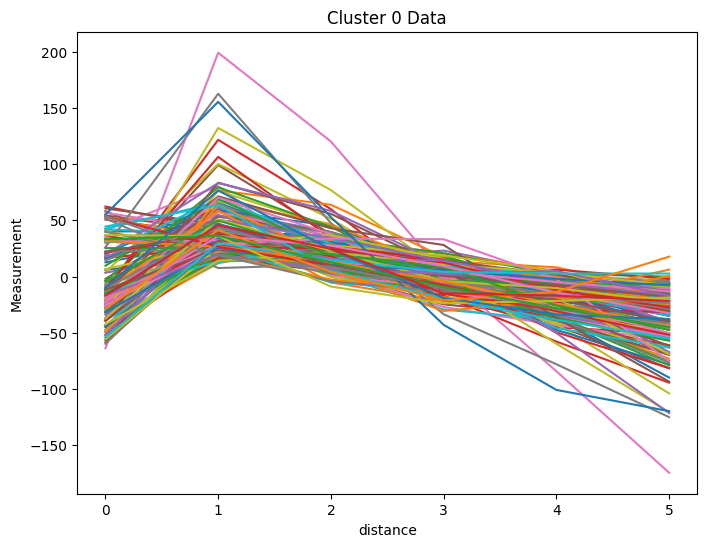

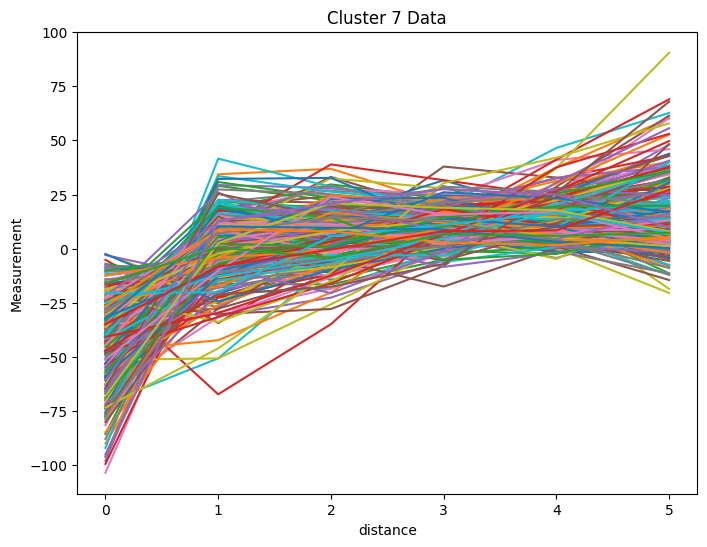

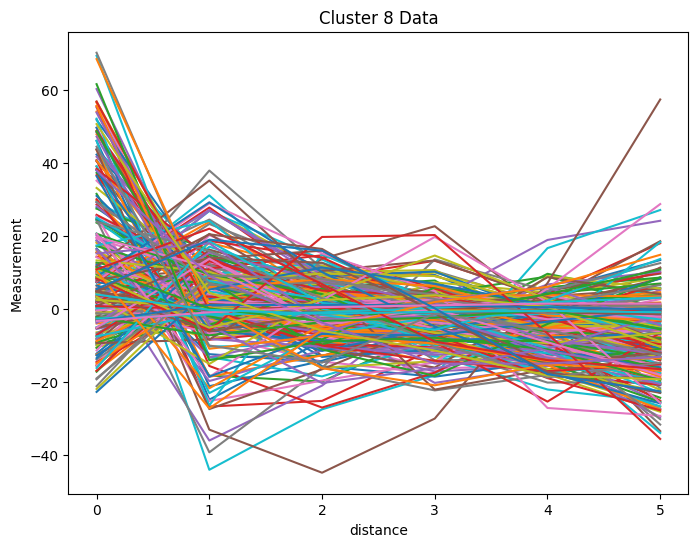

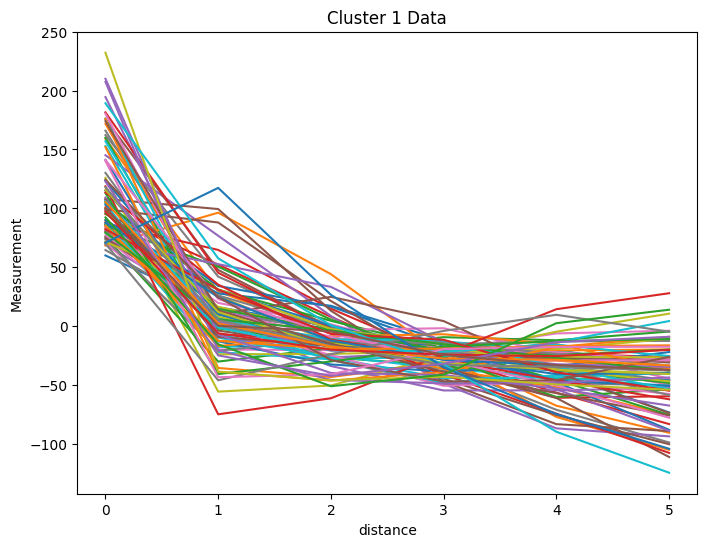

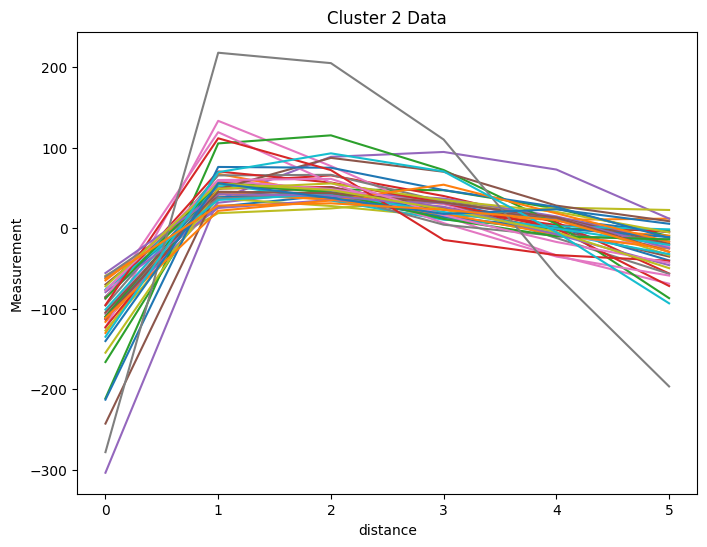

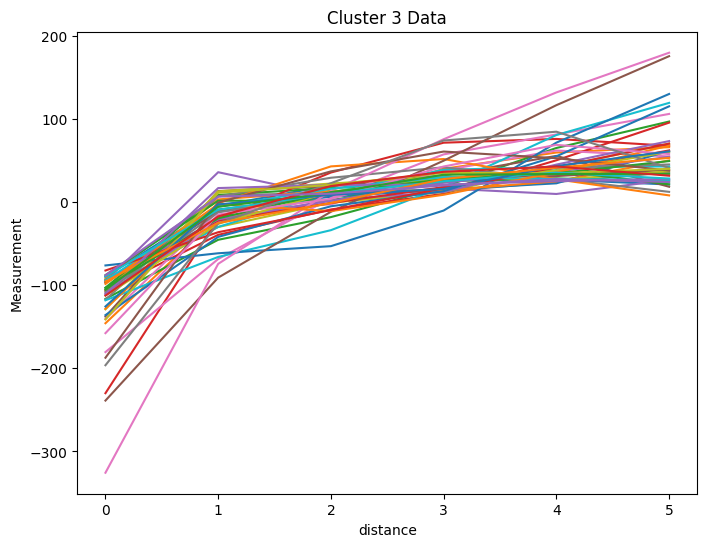

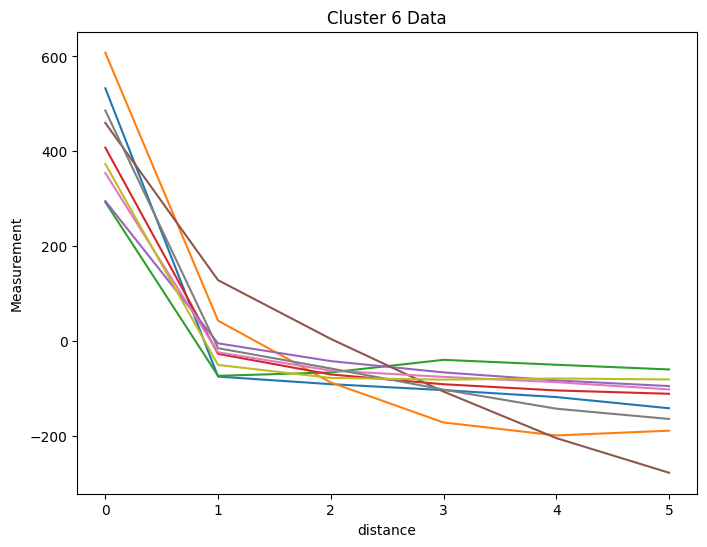

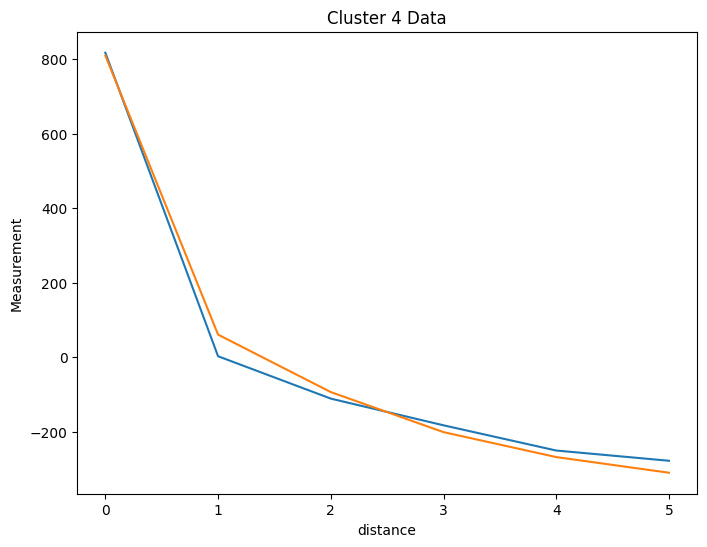

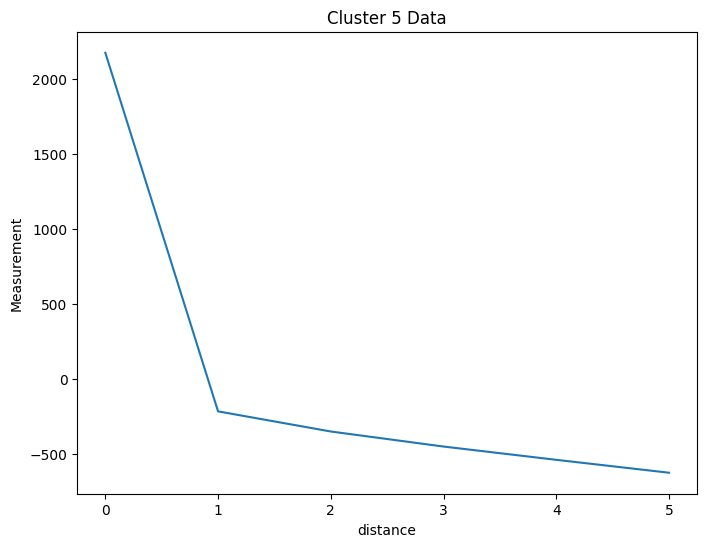

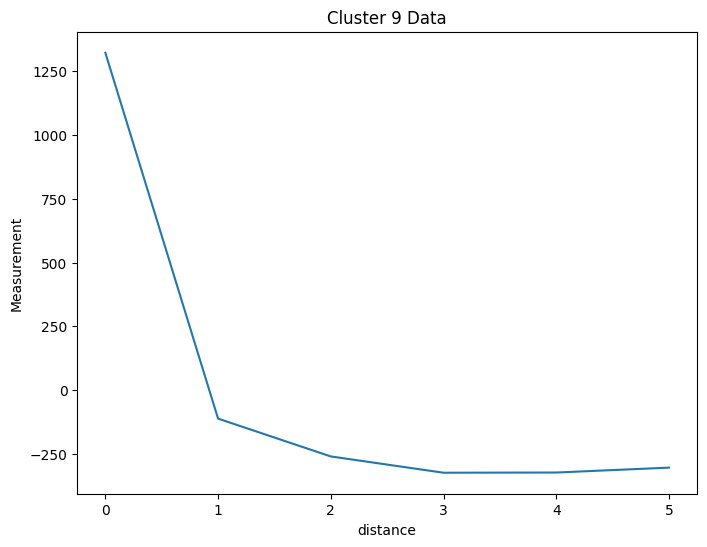

In [7]:
df_gal3_norm, df_gal3_cleaned_sorted = df_cleaning(df_gal3)
clustering = curves_clustering(df_gal3_norm, cluster_number = 10)

In [ ]:
image_list = []
cluster_num = 2
for i in range(len(df_gal3_norm)):
    if df_gal3_norm['cluster'][i] == cluster_num:
        image = df_gal3_norm.index[i]
        image_path = Path(f"{measurements}{image}.tif").as_posix()
        image_list.append(image_path)

In [ ]:
class MainWindow(QMainWindow):

    def __init__(self, image_list):
        super().__init__()
        self.image_list = image_list
        self.window()
    
    def window(self):
        self.scroll = QScrollArea()
        self.win = QWidget()
        self.grid = QGridLayout()

        num_images = len(self.image_list)
        num_columns = 4  # Fixed number of columns
        num_rows = (num_images + num_columns - 1) // num_columns  # Calculate number of rows dynamically

        n = 0
        for i in range(num_rows):
            for j in range(num_columns):
                if n < num_images:
                    file = self.image_list[n]
                    pixmap = QPixmap(file)
                    pixmap2 = pixmap.scaled(500, 200, Qt.KeepAspectRatio)
                    label = QLabel(pixmap=pixmap2)
                    self.grid.addWidget(label, i, j)
                    n += 1
    
        self.win.setLayout(self.grid)
        self.scroll.setWidgetResizable(True)
        self.scroll.setVerticalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setHorizontalScrollBarPolicy(Qt.ScrollBarAlwaysOn)
        self.scroll.setWidget(self.win)
        self.setCentralWidget(self.scroll)
        self.setGeometry(0, 0, 2300, 1000)
        self.setWindowTitle('Image Viewer')
        self.show()

def main():
    app = QApplication(sys.argv)
    main = MainWindow(image_list)
    sys.exit(app.exec_())

if __name__ == '__main__':
    main()

In [9]:
df_lc3_norm.head()

,d0,d1,d2,d3,d4,d5,cluster
Experiment-2168_1,0.819992,0.113815,-0.059222,-0.116358,-0.255052,-0.503175,5
Experiment-2168_113,0.962027,-0.553516,0.008593,-0.155509,-0.138013,-0.123583,5
Experiment-2168_118,0.323603,-2.413599,-1.095547,-0.485525,0.625056,3.046013,5
Experiment-2168_121,2.689213,-0.191190,-0.292002,-0.445751,-0.821261,-0.939008,5
Experiment-2168_124,2.129344,-0.375374,-0.296443,-0.599087,-0.489154,-0.369285,5


In [41]:
print (len(df_lc3_norm))

846


In [17]:
df_gal3_norm.head()

,d0,d1,d2,d3,d4,d5,cluster
Experiment-2168_1,12.665874,31.480787,18.687803,-0.168931,-17.284402,-45.381132,0
Experiment-2168_113,-14.446621,29.637308,14.014869,2.717695,-14.563414,-17.359837,0
Experiment-2168_118,-42.312083,12.371294,13.580843,8.036811,4.465263,3.857872,7
Experiment-2168_121,-89.990699,-1.886907,3.381977,17.535727,27.287697,43.672205,7
Experiment-2168_124,-35.640688,-1.030895,4.976855,8.086167,10.003395,13.605165,7


In [8]:
clusters_positives_lc3 = [2, 1, 7, 4, 3, 6, 9, 8]
clusters_negatives_lc3 = [5, 0]
clusters_positives_gal3 = [1, 6, 4, 5, 9]
clusters_negatives_gal3 = [0, 7, 8, 2, 3]

In [18]:
lc3_positive = []
gal3_positive = []
double_positive = []
negatives = []

for i in range(len(df_lc3_norm)):
    image = df_lc3_norm.index[i]
    if df_lc3_norm['cluster'][i] in clusters_positives_lc3:
        if df_gal3_norm['cluster'][i] in clusters_positives_gal3:
            double_positive.append(image)
        else:
            lc3_positive.append(image)
            
    elif df_lc3_norm['cluster'][i] in clusters_negatives_lc3:
        if df_gal3_norm['cluster'][i] in clusters_positives_gal3:
            gal3_positive.append(image)
        else:
            negatives.append(image)

In [42]:
total_images = len(df_lc3_norm)
df = pandas.DataFrame({
    'category': ['lc3_positive', 'gal3_positive', 'double_positive', 'negatives'],
    'count': [len(lc3_positive), len(gal3_positive), len(double_positive), len(negatives)]
})
df['% total'] = (df['count'] / total_images) * 100
df.head()

,category,count,% total
0,lc3_positive,41,4.846336
1,gal3_positive,60,7.092199
2,double_positive,39,4.609929
3,negatives,706,83.451537
